In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
from kural_core.train_model import train_model
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML, clear_output
from os import listdir
import time
import math

PATH = r'D:\Code\kural_work\movie_generation\data\\'
crop_img_tensor = torch.load(PATH+'crop_img_tensor.variable')

In [33]:
all_files = os.listdir(PATH)
all_tifs = []
for file in all_files:
    if file[-13:] != 'crop_data.pkl': continue
    all_tifs.append(file)

In [35]:
tifs = []
for i,file in enumerate(all_tifs):
    if '_4s_' in file:
        print(i)
        continue
    tifs.append(file)

7
9
10


In [37]:
tmp_tensor = crop_img_tensor[:4949]

In [38]:
tmp_tensor = torch.cat((tmp_tensor,crop_img_tensor[5527:5828]))

In [39]:
tmp_tensor = torch.cat((tmp_tensor,crop_img_tensor[7324:]))

In [41]:
tifs = [tifs[i][:-14] + '.tif' for i in range(len(tifs))]

In [42]:
nf_list = []
for tif in tifs:
    img_ = Image.open(PATH+tif)
    nf_list.append(img_.n_frames)
nf = np.stack(nf_list)
nf = np.cumsum(nf)
print(nf)

[ 301 1202 2103 3004 3905 4806 4949 5250 6151 7052]


In [43]:
tensor_so_far = tmp_tensor.clone().detach()
nf_so_far = nf.copy()

In [44]:
nf = np.concatenate(([0],nf))
movies = [tmp_tensor[nf[i]:nf[i+1]] for i in range(len(nf)-1)]

In [45]:
ones = []
for i,file in enumerate(tifs):
    if '_1s_' in file:
        ones.append(i)

In [46]:
split_movies = []
for i, movie in enumerate(movies):
    if i in ones:
        split_movies.extend((movie[::2],movie[1::2]))
    else:
        split_movies.append(movie)

In [49]:
nf = np.cumsum(np.array([split_movies[i].shape[0] for i in range(len(split_movies))]));nf

array([ 301, 1202, 1653, 2103, 2554, 3004, 3455, 3905, 4356, 4806, 4949, 5250, 5701, 6151, 7052], dtype=int32)

In [50]:
split_crop_img_tensor = torch.cat(split_movies)

In [86]:
with open(PATH+'split_crop_img_tensor_and_nf.pickle','wb') as f:
    pickle.dump((split_crop_img_tensor,nf),f)  

In [2]:
with open(PATH+'split_crop_img_tensor_and_nf.pickle','rb') as f:
    split_crop_img_tensor, nf = pickle.load(f)

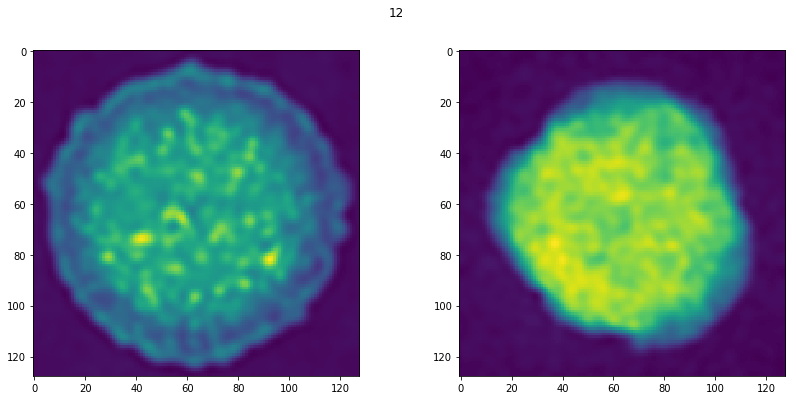

In [18]:
if i>=len(nf)-1: i=0
fig, ax = plt.subplots(1,2,figsize=[14,6])
ax[0].imshow(split_crop_img_tensor[nf[i]-1,0])
ax[1].imshow(split_crop_img_tensor[nf[i],0])
plt.suptitle(str(i))
plt.show()
i+=1

In [12]:
em_model = ConvolutionalAutoencoderModel()
em_model.load_state_dict(torch.load('D:\\Code\\kural_work\\convolutional_autoencoder_model.pth'))
em_model = em_model.eval().cuda()

In [ ]:
ds = FutureImageDataset(split_crop_img_tensor,nf,8,150)
embeddedMovies = torch.zeros((len(ds)*ds.nt,ds.input+1,128))
k = 0
for i in range(len(ds)):
    out_list = ds[i]
    for sequence, future in out_list:
        embeddedMovies[k,:ds.input] = em_model.convolution(sequence.cuda()).data.cpu().view(-1,128)
        embeddedMovies[k,-1] = em_model.convolution(future.cuda()).data.cpu().view(128)
        k+=1

embeddedMovies.transpose_(1,2);

In [30]:
with open(PATH+'splitEmbeddedMovies_5m.pickle','wb') as f:
    pickle.dump(embeddedMovies,f)  

In [24]:
with open(PATH+'splitEmbeddedMovies_5m.pickle','rb') as f:
    embeddedMovies = pickle.load(f)

In [36]:
weird = []
for i in range(embeddedMovies.shape[0]):
    weird.append(torch.all(embeddedMovies[i]==0).item())

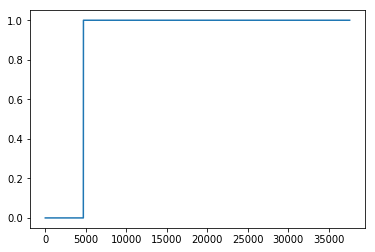

In [37]:
plt.plot(weird)

In [20]:
(nf-np.cumsum((8+150-1)*np.ones_like(nf)))*8

array([ 1152,  7104,  9456, 11800, 14152, 16496, 18848, 21192, 23544,
       25888, 25776, 26928, 29280, 31624, 37576])

In [21]:
holdout_movies = embeddedMovies[31624:].clone().detach()
train_movies = embeddedMovies[:31624].clone().detach()

In [5]:
ds = EmbeddedFutureImageDataset(train_movies)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 100
clip = 50
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True),drop_last=True)
val_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(val_idx),drop_last=True)
model = FuturePrediction1DConvModel().cuda()
lr_start = 3e-3
opt = torch.optim.Adam(model.parameters(),lr=lr_start)
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [8]:
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start, lr_end=1e-5, epochs=5, cycles=1)
train_loss += _tl
val_loss += _vl

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 1m  4s doing 5 total steps for an average of 12.7s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


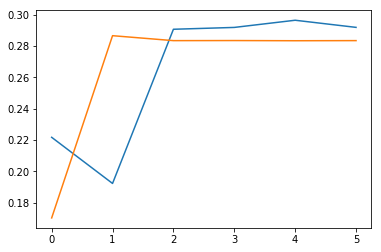

In [9]:
slc = slice(0,len(train_loss))
plt.plot(train_loss[slc])
plt.plot(val_loss[slc])
plt.show()

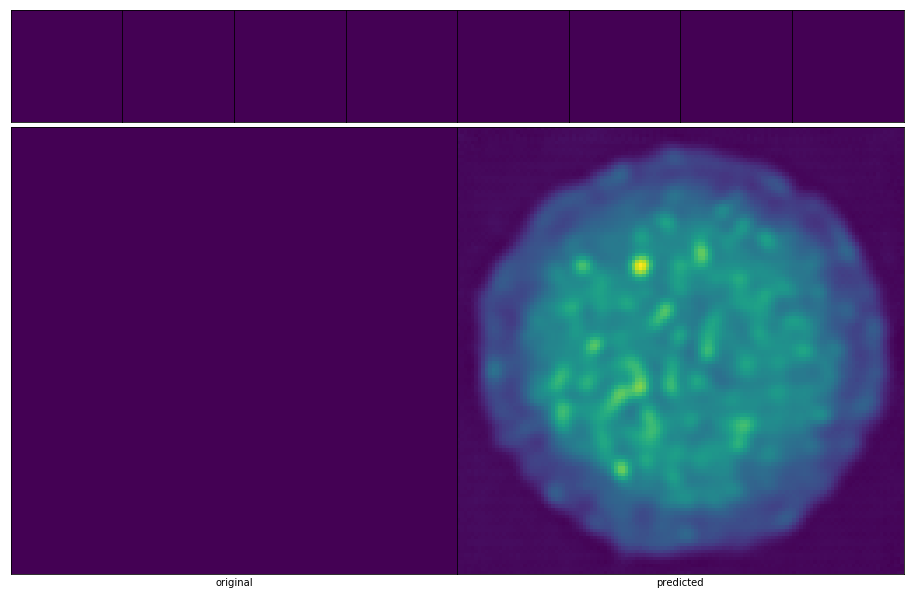

In [13]:
model.eval()
holdout_ds = torch.utils.data.TensorDataset(holdout_movies)
plt.figure(figsize=[16,10])
gs = gridspec.GridSpec(2,8,height_ratios=[1,4],wspace=0,hspace=0,bottom=0,top=.79)
ax = []
for i in range(8):
    ax.append(plt.subplot(gs[0,i]))
ax.append(plt.subplot(gs[1,:4]))
ax.append(plt.subplot(gs[1,4:]))
idx = np.random.choice(len(holdout_ds))
data, = holdout_ds[idx]
for i in range(9):
    img = em_model.deconvolution(data[:,i].view(1,128,1,1).cuda()).data.cpu()
    ax[i].imshow(img.squeeze())
y_pred = model(data[None,:,:-1].cuda())
img =  em_model.deconvolution(y_pred.view(1,128,1,1)).data.cpu()
ax[-1].imshow(img.squeeze())
for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[-2].set_xlabel('original')
ax[-1].set_xlabel('predicted')
plt.show()

In [133]:
data.shape

torch.Size([128, 9])